<a href="https://colab.research.google.com/github/pagaspandhutanoyo/Portofolio-Data/blob/main/Portofolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('onlineretail.csv')

In [ ]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,01-12-09 7:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,01-12-09 7:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,01-12-09 7:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,01-12-09 7:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,01-12-09 7:45,1.25,13085.0,United Kingdom


In [ ]:
df.isnull().sum()

,0
Invoice,0
StockCode,0
Description,4372
Quantity,0
InvoiceDate,0
Price,0
Customer ID,236682
Country,0


In [ ]:
df['Description'].fillna('Unknown', inplace=True)
df.dropna(subset=['Customer ID'], inplace=True)

/tmp/ipython-input-4156991355.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Description'].fillna('Unknown', inplace=True)


In [ ]:
print("Missing values after cleaning:")
print(df.isnull().sum())

Missing values after cleaning:
Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64


In [ ]:
# 1. Buang data yang tidak ada Customer ID-nya (karena kita mau analisis per user)
df = df.dropna(subset=['Customer ID'])

# 2. Buang transaksi yang Quantity-nya minus (biasanya barang retur/batal)
df = df[df['Quantity'] > 0]

# 3. Pastikan format tanggal benar
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 4. Buat kolom 'TotalAmount' (Harga x Jumlah Barang)
df['TotalAmount'] = df['Price'] * df['Quantity']

print("Data Bersih Siap Olah:", df.shape)

/tmp/ipython-input-3594481009.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


Data Bersih Siap Olah: (793380, 9)


In [ ]:
df.to_csv('data_bersih.csv', index=False)

In [ ]:
df_bersih = pd.read_csv('data_bersih.csv')

In [ ]:
df_bersih.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-01-12 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-01-12 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-01-12 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-01-12 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-01-12 07:45:00,1.25,13085.0,United Kingdom,30.0


In [ ]:
print("Missing values in df_bersih after cleaning:")
df_bersih.isnull().sum()

Missing values in df_bersih after cleaning:


,0
Invoice,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
Price,0
Customer ID,0
Country,0
TotalAmount,0


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Tentukan tanggal patokan (anggap kita analisis H+1 dari tanggal terakhir di data)
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Grouping per Customer ID
rfm = df.groupby(['Customer ID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Recency (Jarak hari terakhir belanja)
    'Invoice': 'count', # Frequency (Jumlah kali transaksi)
    'TotalAmount': 'sum' # Monetary (Total uang yang dibelanjakan)
})

# Rename kolom biar rapi
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'TotalAmount': 'Monetary'
}, inplace=True)

display(rfm.head())

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,327,34,77556.46
12347.0,41,242,5408.50
12348.0,77,51,2019.40
12349.0,20,175,4428.69
12350.0,312,17,334.40


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [ ]:
# Log Transformation (untuk mengatasi data yang menceng/skewed, misal ada sultan belanja milyaran sendiri)
rfm_log = np.log(rfm + 1) # Ditambah 1 biar gak error kalau ada angka 0

# Standard Scaling (Mengubah angka jadi skala -1 sampai 1)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

# Masukkan kembali ke DataFrame biar enak dilihat
rfm_scaled_df = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)

In [ ]:
# Kita tentukan misal 3 Cluster (Kamu bisa ganti jadi 4 atau 5)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(rfm_scaled_df)

# Hasil clusternya kita tempel balik ke data asli
rfm['Cluster'] = kmeans.labels_

# Cek rata-rata tiap cluster untuk interpretasi
analysis = rfm.groupby('Cluster').mean().round(1)
display(analysis)

,Recency,Frequency,Monetary
Cluster,,,
0,384.4,17.2,307.9
1,32.8,377.8,8994.7
2,184.1,83.2,1417.9


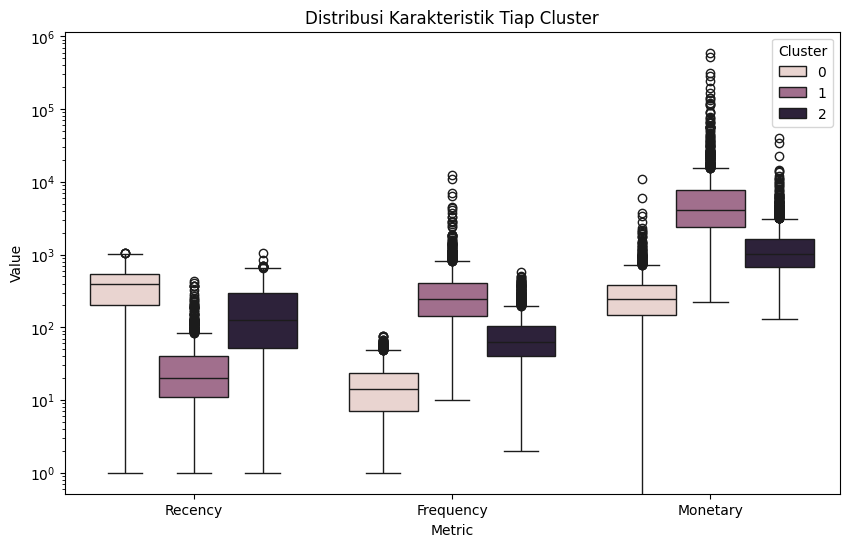

In [ ]:
# Unpivot data (Melt) untuk keperluan visualisasi seaborn
rfm_melted = pd.melt(rfm.reset_index(), id_vars=['Customer ID', 'Cluster'],
                     value_vars=['Recency', 'Frequency', 'Monetary'],
                     var_name='Metric', value_name='Value')

# Visualisasi Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=rfm_melted, x='Metric', y='Value', hue='Cluster')
plt.yscale('log') # Pakai skala log biar grafik gak gepeng
plt.title('Distribusi Karakteristik Tiap Cluster')
plt.show()